URL do serviço de dados de países fornecido pelo IBGE:

https://servicodados.ibge.gov.br/api/docs/paises 


pip install pandasql

In [1]:
# Importação das bibliotecas necessárias

from pyspark.sql import SparkSession
import requests
import pandas as pd  
import pandasql as ps
import sqlite3

spark = SparkSession.builder.appName("Dados_IBGE").getOrCreate()

In [15]:
# Lista de IDs de indicadores a serem recuperados
indicadores = "77844|77849|77845|77846|77850|77851|77852|77823|77827|77825|77826|77819|77820|77857|77831|77832"

# Lista de códigos de países  
paises = "AR|BR|CL|CO|EC|GY|PY|PE|SR|UY|VE" 

# Constrói a URL para a requisição, inserindo os parâmetros de países e indicadores
link = f"https://servicodados.ibge.gov.br/api/v1/paises/{paises}/indicadores/{indicadores}"

# Faz uma requisição GET para a URL especificada
requisicao = requests.get(link)

# Converter a resposta JSON em um dicionário
data = requisicao.json()  

In [3]:
# Lista de indicadores
indicadores = data

# Listas para armazenar os dados
indicador_ids = []
indicador_list = []
unidade_ids = []
classe_unidades = []
paises_list = []
periodos_list = []
resultados_list = []

# Loop através dos indicadores
for indicador_info in indicadores:
    indicador_id = indicador_info['id']   
    indicador = indicador_info['indicador'] 
    
    # Verificar se o campo 'unidade' está presente
    if 'unidade' in indicador_info:
        unidade_id = indicador_info['unidade']['id']  
        classe_unidade = indicador_info['unidade']['classe']  
    else:
        unidade_id = None
        classe_unidade = None
    
    # Loop através dos países  
    for serie in indicador_info['series']:
        pais_nome = serie['pais']['nome']

        # Inicializar um dicionário de resultados vazio para todos os anos disponíveis
        resultados_dict = {str(year): None for year in range(1990, 2023)}

        # Loop através dos dados das séries para o país atual
        for item in serie['serie']:
            periodo = list(item.keys())[0]
            resultado = item[periodo]

            # Verificar se o período é um ano válido (maior ou igual a 2000)
            if periodo.isdigit() and int(periodo) >= 2000:
                resultados_dict[periodo] = resultado

        # Adicionar os valores aos resultados_list
        for periodo, resultado in resultados_dict.items():
            indicador_ids.append(indicador_id)  # ID do indicador
            indicador_list.append(indicador)  # Indicador
            unidade_ids.append(unidade_id)  # ID da unidade
            classe_unidades.append(classe_unidade)  # Classe da unidade
            paises_list.append(pais_nome) # Paises
            periodos_list.append(periodo) # Periodo
            resultados_list.append(resultado) # Resultado

# Criar um DataFrame com os dados extraídos
df_dados = pd.DataFrame({
    'Indicador_ID': indicador_ids,  # ID do indicador
    'Indicador': indicador_list,  # Indicador
    'Unidade_ID': unidade_ids,  # ID da unidade
    'Classe_Unidade': classe_unidades,  # Classe da unidade
    'Pais': paises_list, # Paises
    'Periodo': periodos_list, # Periodo
    'Resultado': resultados_list # Resultado
})

print(df_dados)


      Indicador_ID                                   Indicador Unidade_ID  \
0            77819     Economia - Gastos públicos com educação   % do PIB   
1            77819     Economia - Gastos públicos com educação   % do PIB   
2            77819     Economia - Gastos públicos com educação   % do PIB   
3            77819     Economia - Gastos públicos com educação   % do PIB   
4            77819     Economia - Gastos públicos com educação   % do PIB   
...            ...                                         ...        ...   
5803         77857  Redes - Percentual de usuários de Internet          %   
5804         77857  Redes - Percentual de usuários de Internet          %   
5805         77857  Redes - Percentual de usuários de Internet          %   
5806         77857  Redes - Percentual de usuários de Internet          %   
5807         77857  Redes - Percentual de usuários de Internet          %   

     Classe_Unidade       Pais Periodo Resultado  
0                 N    E

In [13]:
# Query para criar extração de paises

paises = """
        WITH CTE AS (
            SELECT DISTINCT Pais
            FROM df_dados
        )
        SELECT ROW_NUMBER() OVER () AS Pais_ID, Pais
        FROM CTE 
"""

# Execute a consulta
resultado_consulta_paises = ps.sqldf(paises, locals())

# Exiba o resultado da consulta
print(resultado_consulta_paises)

# Extrai para um arquivo csv
resultado_consulta_paises.to_csv('dim_paises.csv', index=False, sep=';')

    Pais_ID       Pais
0         1    Equador
1         2       Peru
2         3  Argentina
3         4   Colômbia
4         5   Paraguai
5         6   Suriname
6         7    Uruguai
7         8     Brasil
8         9      Chile
9        10     Guiana
10       11  Venezuela


In [10]:
# Query para criar extração de periodo

periodo =  """ 
            SELECT DISTINCT Periodo 
            FROM df_dados 
"""
 
# Execute a consulta
resultado_consulta_periodo = ps.sqldf(periodo, locals())

# Exiba o resultado da consulta
print(resultado_consulta_periodo)

# Extrai para um arquivo csv
resultado_consulta_periodo.to_csv('dim_periodo.csv', index=False, sep=';')

   Periodo
0     1990
1     1991
2     1992
3     1993
4     1994
5     1995
6     1996
7     1997
8     1998
9     1999
10    2000
11    2001
12    2002
13    2003
14    2004
15    2005
16    2006
17    2007
18    2008
19    2009
20    2010
21    2011
22    2012
23    2013
24    2014
25    2015
26    2016
27    2017
28    2018
29    2019
30    2020
31    2021
32    2022


In [11]:
# Query para criar extração de indicadores

indicadores =   """  
                SELECT DISTINCT Indicador_ID, Indicador, Unidade_ID                                            
                FROM df_dados  
""" 

# Execute a consulta
resultado_consulta_indicador = ps.sqldf(indicadores, locals())

# Exiba o resultado da consulta
print(resultado_consulta_indicador)

# Extrai para um arquivo csv
resultado_consulta_indicador.to_csv('dim_indicadores.csv', index=False, sep=';')

    Indicador_ID                                          Indicador  \
0          77819            Economia - Gastos públicos com educação   
1          77820               Economia - Gastos públicos com saúde   
2          77823                          Economia - PIB per capita   
3          77825                    Economia - Total de exportações   
4          77826                    Economia - Total de importações   
5          77827                            Economia - Total do PIB   
6          77831  Indicadores sociais - Índice de desenvolviment...   
7          77832  Indicadores sociais - População com acesso à á...   
8          77844                  População - Densidade demográfica   
9          77845                                 População - Homens   
10         77846                               População - Mulheres   
11         77849                        População - População total   
12         77850              População - Taxa bruta de mortalidade   
13    

In [14]:
# Query para criar extração de resultados

resultados =  """ 
            SELECT DISTINCT Indicador_ID, B.Pais_ID, Periodo, Resultado                                   
            FROM df_dados as A
            LEFT JOIN resultado_consulta_paises AS B 
            ON A.Pais = B.Pais 
            WHERE Resultado IS NOT NULL
""" 

# Execute a consulta
resultado_consulta_resultados = ps.sqldf(resultados, locals())

# Exiba o resultado da consulta
print(resultado_consulta_resultados)

# Extrai para um arquivo csv
resultado_consulta_resultados.to_csv('fato_resultados.csv', index=False, sep=';')

      Indicador_ID  Pais_ID Periodo Resultado
0            77819        1    2000      1.15
1            77819        1    2009      4.34
2            77819        1    2010      4.51
3            77819        1    2011      4.73
4            77819        1    2012      4.64
...            ...      ...     ...       ...
3727         77857       11    2013      54.9
3728         77857       11    2014        57
3729         77857       11    2015        58
3730         77857       11    2016        60
3731         77857       11    2017      61.6

[3732 rows x 4 columns]


**MODELO DE DADOS**

A estrutura do modelo de dados será configurada no formato Star Schema, organizada da seguinte forma:

A tabela fato central será composta por identificadores (IDs) que estabelecem relações com as tabelas de dimensões. Ela armazenará exclusivamente os IDs e os valores dos resultados, mantendo-se concisa e focada nos dados de performance.

As tabelas de dimensões serão enriquecidas com IDs, descrições detalhadas e colunas adicionais contendo informações complementares. Essas tabelas servirão para contextualizar e dar profundidade aos dados contidos na tabela fato.

Especificamente para a dimensão 'período', a estrutura atual contém apenas o próprio ID. No entanto, o design já considera uma expansão futura dessa dimensão. Isso permite a inclusão de atributos adicionais, como mês e descrições detalhadas, sem necessidade de reestruturação significativa.
 

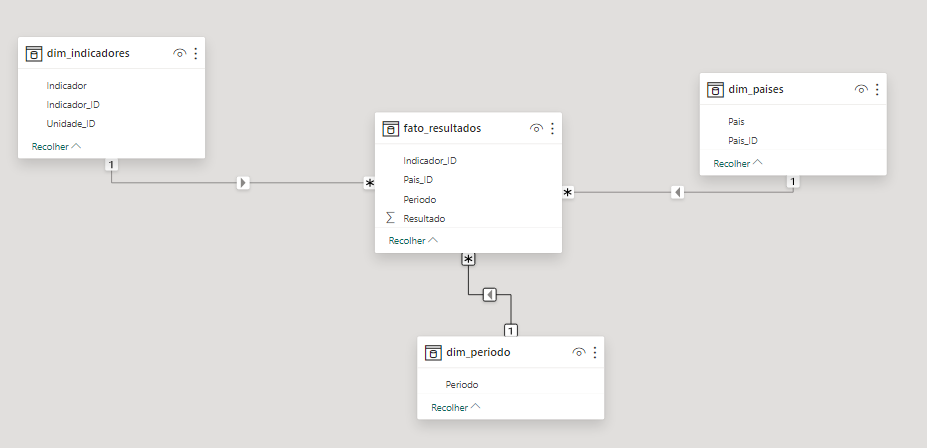

**FLUXO DE DADOS**

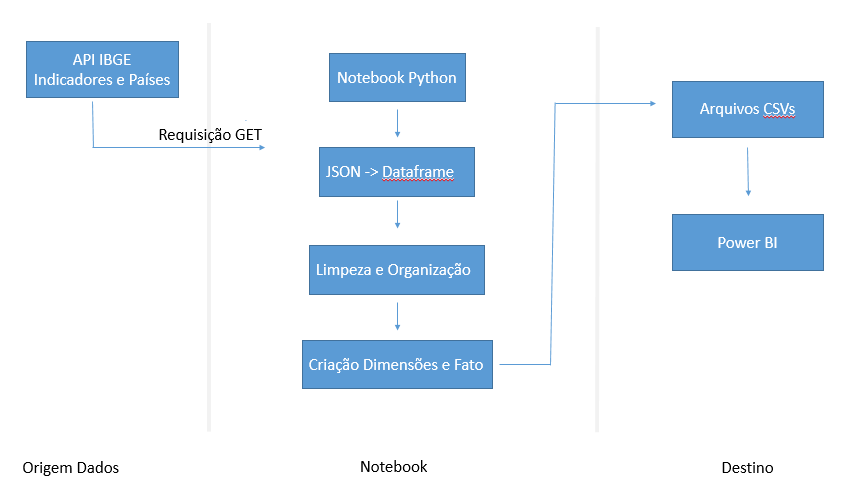